In [15]:
!pip install matplotlib
!pip install tensorflow_datasets
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [16]:
dataset = tfds.builder('celeb_a')
dataset.download_and_prepare()

physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
data = dataset.as_dataset(shuffle_files=False)
data_train = data['train']
data_validation = data['validation']
data_test = data['test']


#data_train = data_train1.concatenate(data_test)


In [18]:
#data_test2 = data_validation

#nt = 0
#for i in data_test2:
#    cnt += 1
#print(cnt)

In [19]:
def preprocess(example, size = (64,64), mode = 'train'):
    image = example['image']
    #print(image.shape)
    label = example['attributes']['Male']
    #print(label)
    if mode == 'train':
        image_crop = tf.image.random_crop(image, size = (178, 178, 3))
        image_resized = tf.image.resize(image_crop, size = size)
        image_flip = tf.image.random_flip_left_right(image_resized)
        return (image_flip/255, tf.cast(label, tf.int32))
    else:
        image_cropped = tf.image.crop_to_bounding_box(
            image, 0, 0, 178, 178)
        image_resized = tf.image.resize(
            image_cropped, size=size)
        print(image_resized/255.0, tf.cast(label, tf.int32))
        return (image_resized/255.0, tf.cast(label, tf.int32))
    
    

In [20]:
data_train  = data_train.take(162850)
data_validation = data_validation.take(1000)

BATCH_SIZE = 128
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)
steps_per_epoch = np.ceil(162850/BATCH_SIZE)


ds_train = data_train.map(
    lambda x: preprocess(x, mode='train'))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)

ds_valid = data_validation.map(
    lambda x: preprocess(x, mode='validation'))
ds_valid = ds_valid.batch(BATCH_SIZE)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Tensor("truediv:0", shape=(64, 64, 3), dtype=float32) Tensor("Cast:0", shape=(), dtype=int32)


In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),padding = 'same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2,2)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv2D(64,(3, 3),padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2,2)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv2D(128,(3,3),padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2,2)),
    tf.keras.layers.Conv2D(256,(3, 3),padding='same',activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation=None),
])

In [22]:
tf.random.set_seed(1)
model.compute_output_shape(input_shape=(None, 64, 64, 3))
model.build(input_shape=(None, 64, 64, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)      

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
history = model.fit(ds_train, validation_data=ds_valid, 
                    epochs=20, steps_per_epoch=steps_per_epoch)

Epoch 1/20
1273/1273 [==============================] - 144s 113ms/step - loss: 0.4652 - accuracy: 0.7501 - val_loss: 0.2817 - val_accuracy: 0.8590
Epoch 2/20
1273/1273 [==============================] - 141s 111ms/step - loss: 0.2438 - accuracy: 0.8912 - val_loss: 0.1858 - val_accuracy: 0.9130
Epoch 3/20
1273/1273 [==============================] - 120s 94ms/step - loss: 0.2013 - accuracy: 0.9116 - val_loss: 0.2097 - val_accuracy: 0.8820
Epoch 4/20
1273/1273 [==============================] - 111s 87ms/step - loss: 0.1769 - accuracy: 0.9232 - val_loss: 0.1419 - val_accuracy: 0.9310
Epoch 5/20
1273/1273 [==============================] - 115s 91ms/step - loss: 0.1619 - accuracy: 0.9312 - val_loss: 0.1683 - val_accuracy: 0.9050
Epoch 6/20
1273/1273 [==============================] - 115s 90ms/step - loss: 0.1494 - accuracy: 0.9374 - val_loss: 0.1167 - val_accuracy: 0.9450
Epoch 7/20
1273/1273 [==============================] - 112s 88ms/step - loss: 0.1397 - accuracy: 0.9418 - val_loss:

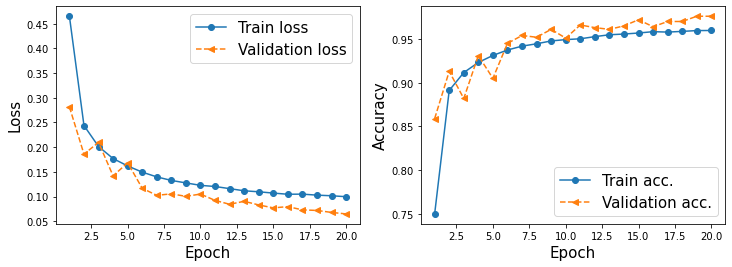

In [25]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/15_18.png', dpi=300)
plt.show()

In [26]:
ds_test = data_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('Test Acc: {:.2f}%'.format(results[1]*100))





Tensor("truediv:0", shape=(64, 64, 3), dtype=float32) Tensor("Cast:0", shape=(), dtype=int32)
Test Acc: 96.98%


0.9961160520900324


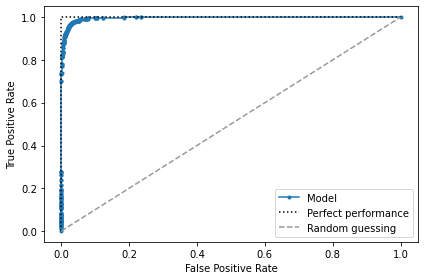

In [59]:
ds = ds_test.unbatch().take(3500)
#print(ds)

#print(ds.batch(10))
pred_logits = model.predict(ds.batch(3500))
#print(pred_logits)
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

y_pred = []
y = []
score = []
for j,example in enumerate(ds):
    if example[1].numpy() == 1:
        y.append(1)
    else:
        y.append(0)
    score.append(probas[j])
    if probas[j] >= 50:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
    
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y = np.array(y)
y_pred = np.array(y_pred)
score = np.array(score)
#print(y)
fpr, tpr, thresholds = metrics.roc_curve(y, score, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.plot(fpr, tpr, marker='.', label='Model')
plt.plot([0, 0, 1],[0, 1, 1],linestyle=':',color='black',label='Perfect performance')
plt.plot([0, 1],[0, 1],linestyle='--',color=(0.6, 0.6, 0.6),label='Random guessing')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
for i in range(0, 110, 10):
    y_pred = []
    for j,example in enumerate(ds):
        if probas[j] >= i:
            y_pred.append(1)
        else:
            y_pred.append(0)
    print("----------Iter", i,'----------')
    print('Precision: %.3f' % precision_score(y_true=y, y_pred=y_pred))
    print('Recall: %.3f' % recall_score(y_true=y, y_pred=y_pred))
    print('F1: %.3f' % f1_score(y_true=y, y_pred=y_pred))
    print('accuracy_score: %.3f' % accuracy_score(y_true=y, y_pred=y_pred))


----------Iter 0 ----------
Precision: 0.394
Recall: 1.000
F1: 0.565
accuracy_score: 0.394
----------Iter 10 ----------
Precision: 0.881
Recall: 0.995
F1: 0.934
accuracy_score: 0.945
----------Iter 20 ----------
Precision: 0.917
Recall: 0.989
F1: 0.952
accuracy_score: 0.961
----------Iter 30 ----------
Precision: 0.939
Recall: 0.980
F1: 0.959
accuracy_score: 0.967
----------Iter 40 ----------
Precision: 0.952
Recall: 0.974
F1: 0.963
accuracy_score: 0.970
----------Iter 50 ----------
Precision: 0.958
Recall: 0.964
F1: 0.961
accuracy_score: 0.969
----------Iter 60 ----------
Precision: 0.967
Recall: 0.949
F1: 0.958
accuracy_score: 0.967
----------Iter 70 ----------
Precision: 0.974
Recall: 0.935
F1: 0.954
accuracy_score: 0.965
----------Iter 80 ----------
Precision: 0.980
Recall: 0.917
F1: 0.948
accuracy_score: 0.960
----------Iter 90 ----------
Precision: 0.990
Recall: 0.864
F1: 0.923
accuracy_score: 0.943
----------Iter 100 ----------
Precision: 1.000
Recall: 0.009
F1: 0.019
accuracy_s

In [64]:
model.save('model_last.h5')
